In [ ]:
import pyabf 


abf = pyabf.ABF("data/2025_12_04_0001.abf")  # load the file
abf.setSweep(0,channel= 0)  # Channel 0 is recording channel
spike_ch = abf.sweepY.copy()
time_vec = abf.sweepX.copy()

abf.setSweep(0,channel= 2)  # Channel 2 is Stim channel
stim_ch = abf.sweepY.copy()
stim_ch_m = max(stim_ch)
stim_ch = (stim_ch-stim_ch_m)*-1


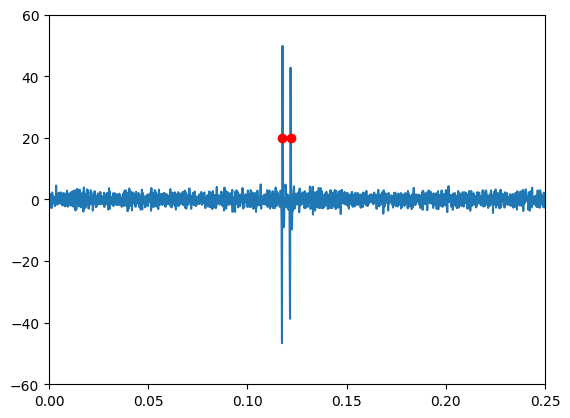

(np.float64(0.0), np.float64(5.0), np.float64(-60.0), np.float64(60.0))

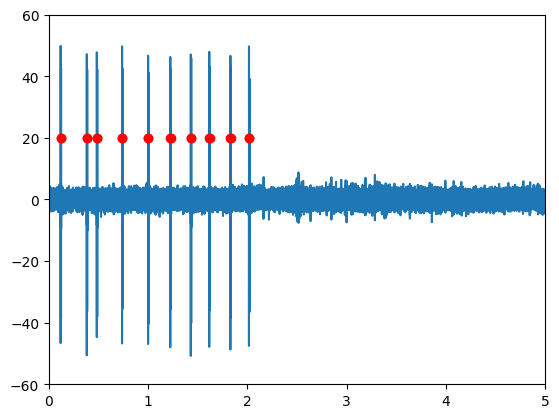

In [ ]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
peaks, _ = find_peaks(spike_ch, height = 20)
plt.plot(time_vec,spike_ch)
plt.plot(peaks/2e4,[20]*len(peaks),'o',c = 'red')
plt.axis([0, 0.25, -60, 60])
plt.show()


plt.plot(time_vec,spike_ch)
plt.plot(peaks/2e4,[20]*len(peaks),'o',c = 'red')
plt.axis([0, 5, -60, 60])

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Change filename as needed
df = pd.read_csv("data/2025_12_04_0001.csv", header=None)


t_60 = df.iloc[:, 1].to_numpy()  
x_60 = df.iloc[:, 2].to_numpy()  


order = np.argsort(t_60)
t_60 = t_60[order]
x_60 = x_60[order]


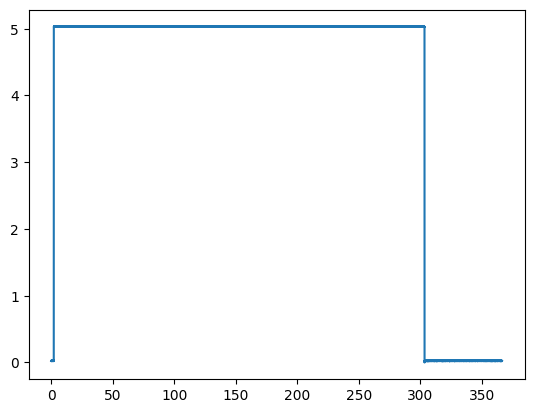

In [11]:
plt.plot(time_vec,stim_ch)

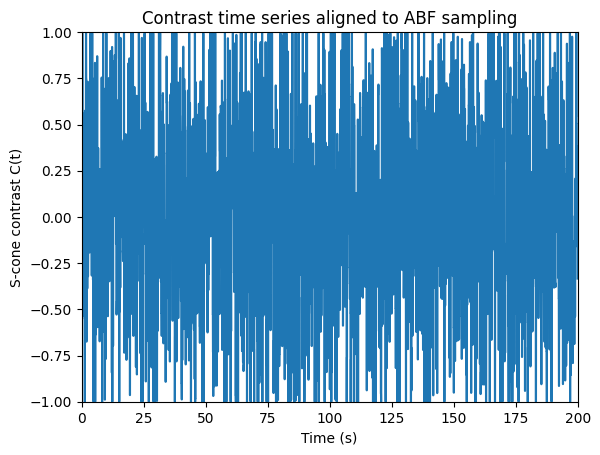

In [14]:
import matplotlib.pyplot as plt
import numpy as np

is_on = stim_ch > 1
edges = np.diff(is_on.astype(int))
fall_idxs = np.where(edges == -1)[0] + 1  
rise_idxs = np.where(edges ==  1)[0] + 1   

i_on = rise_idxs[0]
i_off  = fall_idxs[0]


t_on  = time_vec[i_on]
t_off = time_vec[i_off]


csv = pd.read_csv("data/2025_12_04_0001.csv")

t_60 = csv.iloc[:, 1].to_numpy()
y_60 = csv.iloc[:, 2].to_numpy()

y0 = y_60.mean()
C_60 = (y_60 - y0) / y0

contrast_interp = interp1d(
    t_60, C_60,
    kind='previous',     
    bounds_error=False,
    fill_value=(0.0, 0.0)
)
C_20k = contrast_interp(time_vec)   

plt.plot(time_vec, C_20k)
plt.xlabel("Time (s)")
plt.ylabel("S-cone contrast C(t)")
plt.title("Contrast time series aligned to ABF sampling")
plt.axis([0,200,-1,1])
plt.show()

segments.shape: (2698, 4000)


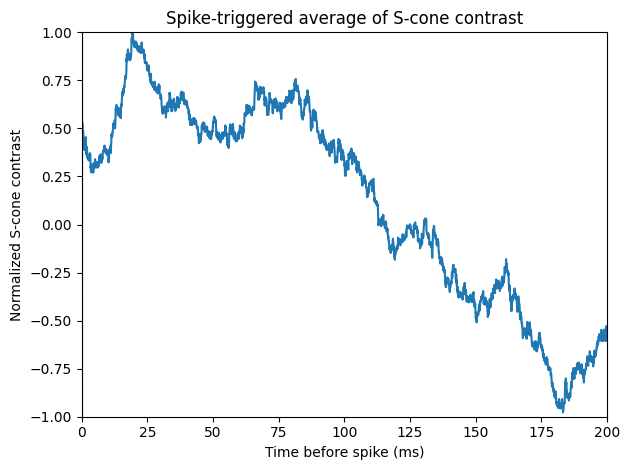

In [17]:
import numpy as np

dt = np.mean(np.diff(time_vec))
fs = 1.0 / dt

window_s = 0.2   # 200 ms
window_n = int(window_s * fs)


spike_times = time_vec[peaks]

mask_spikes = (spike_times >= t_on + 1.0) & (spike_times <= t_off)
peaks_used  = peaks[mask_spikes]

segments = []

for p in peaks_used:

    if p < window_n:
        continue
    if p > len(C_20k):
        continue

    seg = C_20k[p - window_n : p]

    if len(seg) == window_n:
        segments.append(seg)

segments = np.array(segments)  
print("segments.shape:", segments.shape)

sta = segments.mean(axis=0)


sta_rev = sta[::-1]
peak_sta = np.max(np.abs(sta_rev))
sta_norm = sta_rev / peak_sta

lags_ms = np.arange(window_n) * dt * 1000

plt.figure()
plt.plot(lags_ms, sta_norm)
plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel("Time before spike (ms)")
plt.ylabel("Normalized S-cone contrast")
plt.title("Spike-triggered average of S-cone contrast")
plt.axis([0, 200,-1,1])
plt.tight_layout()
plt.show()
